# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 10</span>

### Exercise 10.1

Choose **ONLY ONE** of the two following possibilities:

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 11, is characterized by a different temperature or a limited set of temperatures (if you need more than 11 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lower temperature.

Per questo esercizio, ho implementato un codice che esegue lo stesso programma dell'esercitazione 9 su 7 core simultaneamente, simulando continenti separati in cui avviene una selezione naturale indipendente. Ho aggiunto la possibilità che questi continenti interagiscano tra loro, mescolando gli individui migliori per aumentare la variabilità genetica.

In particolare, ho introdotto il parametro $p_{migr}$, che rappresenta la probabilità di migrazione. Quando questa è attiva, il rank = 0 estrae con probabilità $p_{migr}$ due numeri che identificano due continenti differenti; questi si scambiano i due migliori individui con i due peggiori. Ho anche provato a scambiare i due migliori con individui estratti casualmente secondo la legge $j= int(N_{pop} \times r^{1/p})+1$ con $p>1$, a favorire dunque i path peggiori, tuttavia con risultati leggermente peggiori.

Quello che ho notato, per questo problema, è che la probabilità di migrazione non deve essere troppo alta, altrimenti i continenti smettono di essere "separati" e il codice diventa simile ad usare un solo continente con un numero di path pari a $n_{core}\times N_{path}$. Invece, proprio il fatto che i continenti siano isolati e dunque indipendenti permette un migliore variabilità genetica complessiva.

Per il calcolo parallelo ho usato 7 core, e ho confrontato il caso di continenti con e senza migrazioni (quindi imponendo $p_{migr}=1$). Ho in entrambi icasi usato i seguenti parametri:

- $N_{iter}=2500$
- $N_{path}=3000$
- $p_{cross}=0.8$
- $p=2.2$
- $mutazioni: $p_{pairperm}=0.25$, $p_{shift}=0.1$, $p_{permute}=0.1$, $p_{inverse}=0.2$
- $p_{migr} = 0.05/0$

Il risultato migliore che ho trovato è quello esposto nella cartina.

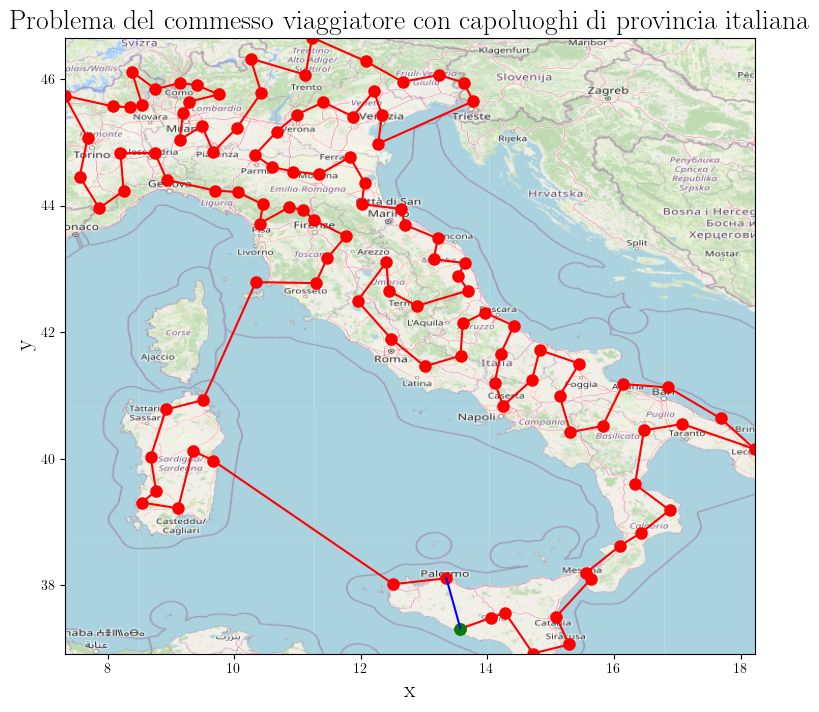

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Impostazioni per utilizzare LaTeX nei testi
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Leggi i punti (x, y) dal file città.dat
with open('GA/esercizio_10.1/cap_prov_ita.dat', 'r') as file:
    cities_data = [tuple(map(float, line.strip().split())) for line in file]

# Leggi l'ordine dei punti dal file risultati2.dat
with open('GA/esercizio_10.1/OUTPUT_PARALL/best') as file:
    next(file)
    order = list(map(int, file.readline().strip().split()))

# Estrai i punti nell'ordine specificato
ordered_cities = [cities_data[i] for i in order]

# Estrai le coordinate x e y dai punti
x = [city[0] for city in ordered_cities]
y = [city[1] for city in ordered_cities]

# Imposta le dimensioni della figura
plt.figure(figsize=(10, 8))  # Imposta larghezza e altezza della figura

# Plotta l'immagine di sfondo
background_image = plt.imread('italy.png')
plt.imshow(background_image, extent=[min(x), max(x), min(y), max(y)])

# Plotta i punti
plt.plot(x, y, marker='o', linestyle='-', color='red', markersize=8, label='città')

# Plotta il punto iniziale
plt.plot(x[0], y[0], marker='o', linestyle='', color='green', markersize=8, label='città iniziale')

# Connetti l'ultimo punto al primo
plt.plot([x[-1], x[0]], [y[-1], y[0]], linestyle='-', color='blue', label='ultimo spostamento')

plt.title('Problema del commesso viaggiatore con capoluoghi di provincia italiana', fontsize=20)
plt.xlabel('x', fontsize=17)
plt.ylabel('y', fontsize=17)

#plt.legend()
plt.show()



### Exercise 10.2

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

Le lunghezze dei due migliori percorsi trovati con e senza migrazioni sono:

In [2]:
def read_third_line(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            if len(lines) >= 3:
                return lines[2].strip()
            else:
                raise ValueError(f"Il file {file_path} non contiene almeno tre righe.")
    except FileNotFoundError:
        raise FileNotFoundError(f"Il file {file_path} non è stato trovato.")
    except Exception as e:
        raise Exception(f"Errore nella lettura del file {file_path}: {e}")

def main():
    file_path_parallel = 'GA/esercizio_10.1/OUTPUT_PARALL/best'
    file_path_single = 'GA/esercizio_10.1/OUTPUT_SINGLE/best'
    
    try:
        length_parallel = read_third_line(file_path_parallel)
        length_single = read_third_line(file_path_single)
        
        print(f"Lunghezza del percorso migliore nel caso di 7 continenti con migrazione:      {length_parallel}")
        print(f"Lunghezza del percorso migliore nel caso di 7 continenti senza migrazione:    {length_single}")
    except Exception as e:
        print(e)

if __name__ == "__main__":
    main()


Lunghezza del percorso migliore nel caso di 7 continenti con migrazione:      64.8342
Lunghezza del percorso migliore nel caso di 7 continenti senza migrazione:    65.7929


Nel grafico seguente invece è presente la media sui diversi continenti dei valori medi della metà popolazione più corta.

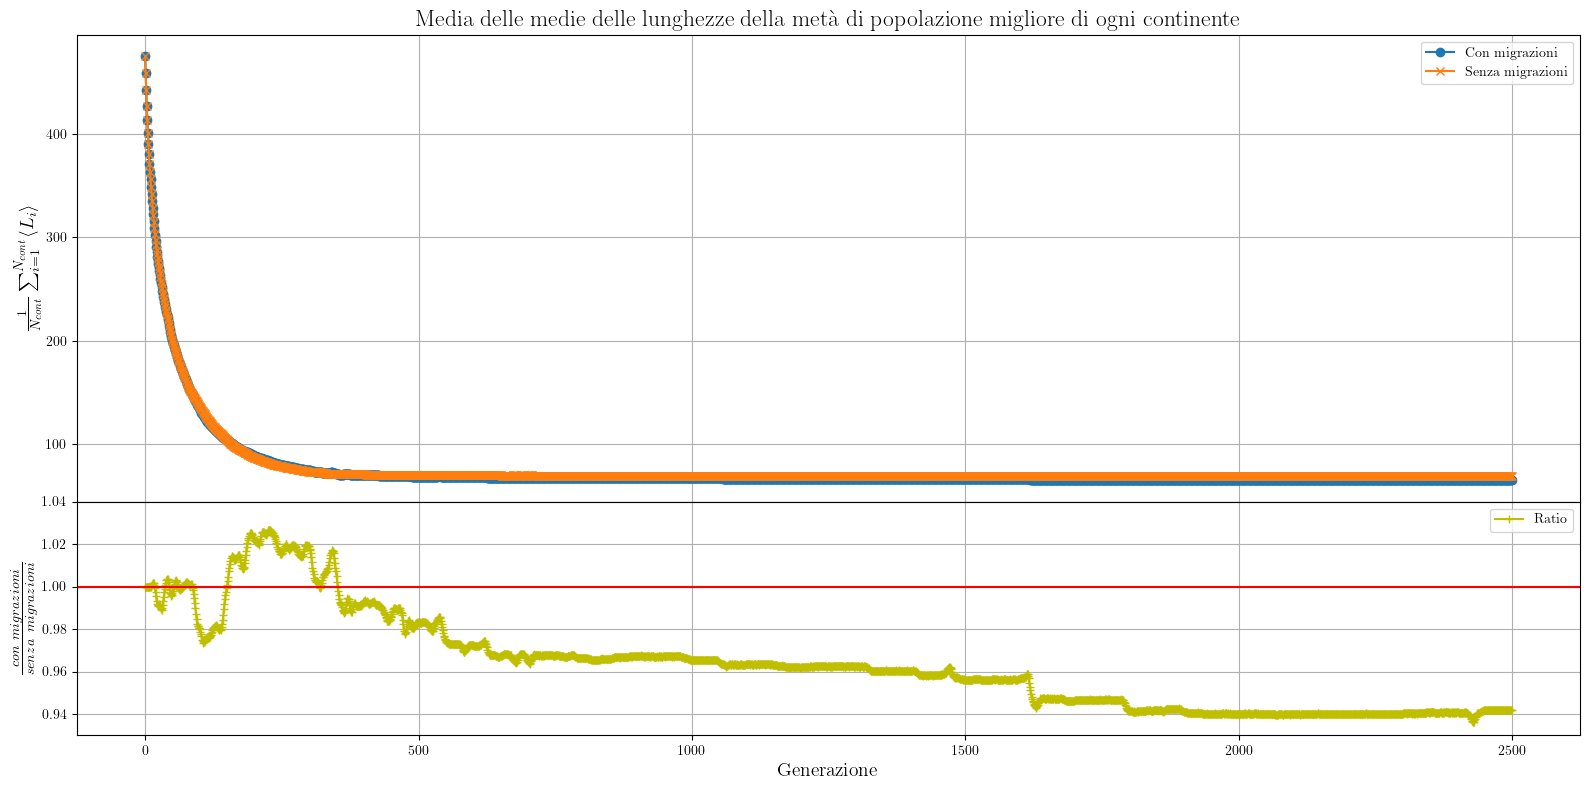

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def read_mean_files(base_path, subdirectories):
    data = []
    for subdir in subdirectories:
        file_path = f"{base_path}/{subdir}/mean.dat"
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
        except FileNotFoundError:
            print(f"File {file_path} non trovato.")
            return None
        except Exception as e:
            print(f"Errore nella lettura del file {file_path}: {e}")
            return None
    return np.array(data)

def calculate_mean(data):
    return np.mean(data, axis=0)

def main():
    parallel_base_path = 'GA/esercizio_10.1/OUTPUT_PARALL'
    single_base_path = 'GA/esercizio_10.1/OUTPUT_SINGLE'
    subdirs = [f'P{i}' for i in range(1, 8)]
    
    # Read and process parallel data
    parallel_data = read_mean_files(parallel_base_path, subdirs)
    if parallel_data is None:
        print("Errore nella lettura dei file paralleli.")
        return
    
    parallel_means = calculate_mean(parallel_data)
    
    # Read and process single data
    single_data = read_mean_files(single_base_path, subdirs)
    if single_data is None:
        print("Errore nella lettura dei file singoli.")
        return
    
    single_means = calculate_mean(single_data)
    
    # Extract only the y-values (second column)
    parallel_y_means = parallel_means[:, 1]
    single_y_means = single_means[:, 1]
    
    # Calculate the ratio of parallel to single means
    ratio_means = parallel_y_means / single_y_means
    
    # Create a figure with two subplots, one below the other
    fig, ax = plt.subplots(2, 1, figsize=(16, 8), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
    
    # Plot the means on the first subplot
    ax[0].plot(parallel_y_means, label='Con migrazioni', marker='o')
    ax[0].plot(single_y_means, label='Senza migrazioni', marker='x')
    ax[0].set_title('Media delle medie delle lunghezze della metà di popolazione migliore di ogni continente', fontsize = 17)
    ax[0].set_ylabel(r'$\frac{1}{N_{cont}}\sum_{i = 1}^{N_{cont}}\langle L_i \rangle$', fontsize = 14)
    ax[0].legend()
    ax[0].grid(True)
    
    # Plot the ratio on the second subplot
    ax[1].plot(ratio_means, label='Ratio', marker='+', color='y')
    ax[1].axhline(1, color='red', linestyle='-')  # Add horizontal line at y=1
    ax[1].set_xlabel('Generazione', fontsize = 14)
    ax[1].set_ylabel(r'$\frac{con\ migrazioni}{senza\ migrazioni}$', fontsize = 14)
    ax[1].set_ylim(0.93, 1.04)
    ax[1].legend()
    ax[1].grid(True)
    
    # Adjust layout to make sure plots are aligned and touching
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.00)  # Adjust the vertical space between plots to make them touch
    
    plt.show()

if __name__ == "__main__":
    main()


Come si può notare il caso con migrazioni ha una convergenza leggermente più lenta nella prima parte, a causa della maggiore stocasticità. Appena però la curva inizia ad appiattirsi, il codice migliore risulta essere nettamente quello con migrazione, in quanto previene il sistema da fermarsi in un minimo locale.

Nei due grafici successivi si può invece osservare la lunghezza del path migliore di ogni continente nei due casi. In neri i punti sono quelli in cui è avvenuta una migrazione.

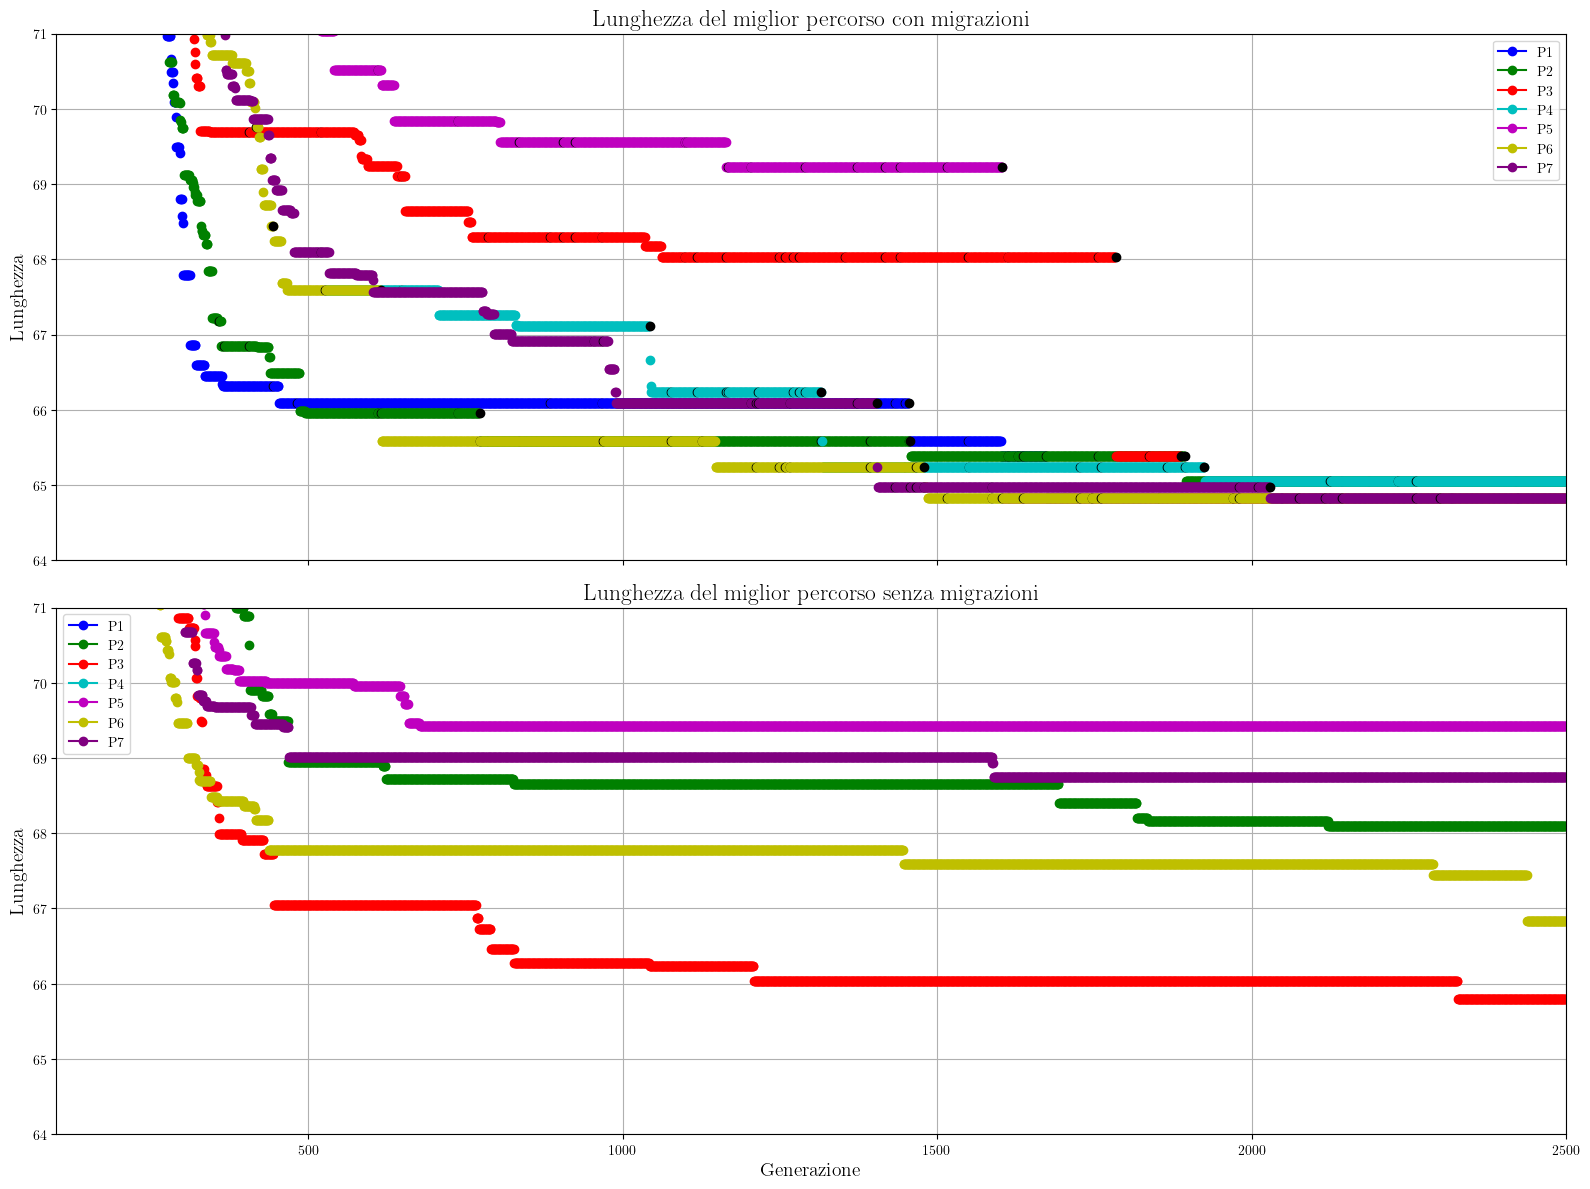

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def read_firstpath_files(base_path, subdirectories):
    data = []
    for subdir in subdirectories:
        file_path = f"{base_path}/{subdir}/firstpath.dat"
        try:
            file_data = np.loadtxt(file_path, usecols=-1)  # Read the last column
            data.append(file_data)
        except FileNotFoundError:
            print(f"File {file_path} non trovato.")
            return None
        except Exception as e:
            print(f"Errore nella lettura del file {file_path}: {e}")
            return None
    return np.array(data)

def plot_data(ax, data, label, marker, color):
    for i in range(len(data)):
        if i > 0 and (data[i] > 1.5 * data[i-1] or (i < len(data) - 1 and data[i] > 1.5 * data[i+1])):
            ax.plot(i, data[i-1], marker=marker, color='black')  # Color the current point black and connect to previous point
        else:
            ax.plot(i, data[i], marker=marker, color=color, label=label if i == 0 else "")
    
    if len(data) > 0:
        ax.plot(0, data[0], marker=marker, color=color)  # Ensure the first point is plotted

def main():
    parallel_base_path = 'GA/esercizio_10.1/OUTPUT_PARALL'
    single_base_path = 'GA/esercizio_10.1/OUTPUT_SINGLE'
    subdirs = [f'P{i}' for i in range(1, 8)]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'purple']  # Different colors for each Pi
    
    # Read parallel data
    parallel_data = read_firstpath_files(parallel_base_path, subdirs)
    if parallel_data is None:
        print("Errore nella lettura dei file paralleli.")
        return
    
    # Read single data
    single_data = read_firstpath_files(single_base_path, subdirs)
    if single_data is None:
        print("Errore nella lettura dei file singoli.")
        return
    
    # Plot parallel data
    fig, axs = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
    
    for i, data in enumerate(parallel_data):
        plot_data(axs[0], data, label=f'P{i+1}', marker='o', color=colors[i])
    
    axs[0].set_title('Lunghezza del miglior percorso con migrazioni', fontsize=17)
    axs[0].set_ylabel('Lunghezza', fontsize=14)
    axs[0].set_ylim(64, 71)
    axs[0].legend()
    axs[0].grid(True)
    
    # Plot single data
    for i, data in enumerate(single_data):
        plot_data(axs[1], data, label=f'P{i+1}', marker='o', color=colors[i])
    
    axs[1].set_title('Lunghezza del miglior percorso senza migrazioni', fontsize=17)
    axs[1].set_xlabel('Generazione', fontsize=14)
    axs[1].set_ylabel('Lunghezza', fontsize=14)
    axs[1].set_xlim(100, 2500)
    axs[1].set_ylim(64, 71)
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Come si può osservare, spesso i salti avvengono in corrisponednza delle migrazioni.